# Natural Language Processing

## Project by Hari

## Part A

**DOMAIN:** Digital content and entertainment industry<br>
**• CONTEXT:** The objective of this project is to build a text classi ication model that analyses the customer's sentiments based on their reviews in the IMDB database. The model uses a complex deep learning model to build an embedding layer followed by a classi ication algorithm to analyse the sentiment of the customers.<br>
**• DATA DESCRIPTION:** The Dataset of 50,000 movie reviews from IMDB, labelled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, the words are indexed by their frequency in the dataset, meaning the for that has index 1 is the most frequent word. Use the irst 20 words from each review to speed up training, using a max vocabulary size of 10,000. As a convention, "0" does not stand for a speci ic word, but instead is used to encode any unknown word.<br>
**• PROJECT OBJECTIVE:** To Build a sequential NLP classi ier which can use input text parameters to determine the
customer sentiments.<br>

**Steps and tasks:**
1. Import and analyse the data set.<br>
Hint:
- Use `imdb.load_data()` method
- Get train and test set
- Take 10000 most frequent words

In [1]:
import numpy as np
import pandas as pd
import datetime, os
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, SpatialDropout1D

In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000,
                                                      oov_char=0)

In [3]:
# review dataset
x_train.shape,y_train.shape

((25000,), (25000,))

In [4]:
x_test.shape,y_test.shape

((25000,), (25000,))

**Steps and tasks:**<br>
2. Perform relevant sequence adding on the data.

let us truncate the review to first 20 characters to speed up training

irrespective of review word lengths, all should been truncated to 20 length, and if necessary padded with ZEROs for shorter reviews

In [5]:
x_train = sequence.pad_sequences(x_train, maxlen=20)
x_test = sequence.pad_sequences(x_test, maxlen=20)

**Steps and tasks:**<br>
3. Perform following data analysis:<br>
• Print shape of features and labels<br>
• Print value of any one feature and it's label<br>

In [6]:
# review dataset
x_train.shape,y_train.shape

((25000, 20), (25000,))

In [7]:
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [8]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((25000, 20), (25000, 1), (25000, 20), (25000, 1))

In [9]:
# review properties of the dataset
np.min(x_train),np.max(x_train),np.min(x_test),np.max(x_test)

(0, 9999, 0, 9999)

In [10]:
np.unique(y_train),np.unique(y_test)

(array([0, 1]), array([0, 1]))

In [11]:
index = np.random.randint(0,len(x_train),size=1)[0]
print('\033[1m'+"FEATURES:"+'\033[0m')
print(x_train[index])
print('\033[1m'+"LABEL"+'\033[0m')
print(y_train[index])

FEATURES:
[  10   21   13 2303  386    7  149   14   20   17   94   55  221    8
   67   89   78   70  142   79]
LABEL
[0]


**Steps and tasks:**<br>
4. Decode the feature value to get original sentence

In [12]:
# lookup dictionaries
w2id = imdb.get_word_index()
w2id.update({'not_in_here':0})
id2w = dict(zip(w2id.values(),w2id.keys()))

In [13]:
index = np.random.randint(0,len(x_train),size=5)
for i in index:
    sentence = ' '.join([id2w[seq] for seq in x_train[i]])
    print('\033[1m'+"FEATURES:"+'\033[0m')
    print(sentence)
    print('\033[1m'+"LABEL"+'\033[0m')
    print(y_train[i])
    print("="*100,'\n')

FEATURES:
mel have this to they there's find so james they being quickly i i was with appearance was plays that
LABEL
[1]

FEATURES:
time very wars continue hollywood br of down people career was lead loved much main of character some br already
LABEL
[1]

FEATURES:
that gorgeous of finest not was well person film that sound probably who not_in_here 0 cast movie be fun under
LABEL
[1]

FEATURES:
was well start to was out one in why is time excellent fiction in though like one convincing as you
LABEL
[1]

FEATURES:
but of not_in_here to them wife by br any minute note that what have well not then ever man production
LABEL
[1]



**Steps and tasks:**<br>
5. Design, train, tune and test a sequential model.<br>
Hint: The aim here Is to import the text, process it such a way that it can be taken as an inout to the ML/NN classi iers. Be
analytical and experimental here in trying new approaches to design the best model.

In [14]:
nVocab = np.max(x_train)+1 #10000
inpSize = x_train.shape [-1]

In [33]:
logFile = "logs/hNet_tuning.har"
logDir = "logs"

In [17]:
grid = dict(embd=[8,16,32],
            lstmN=[64,96,128],
            dOut=[0.2,0.4],
            lRate=[0.1,1e-2,1e-3])

pCols = list(grid.keys())

pGrid = pd.DataFrame(columns=pCols)
for gp in [np.array([e,l,d,lr]) 
           for e in grid["embd"] 
           for l in grid["lstmN"] 
           for d in grid["dOut"] 
           for lr in grid["lRate"]]:
    dtmp = pd.DataFrame(gp.reshape(1,-1),columns=pCols)
    pGrid = pd.merge(pGrid,dtmp,how='outer',on=pCols)

pGrid["epoch"] = np.nan
pGrid.shape

(54, 5)

In [18]:
#let us define a model generating method
def senti(gridPoint):
    embd = int(gridPoint["embd"])
    lstmN = int(gridPoint["lstmN"])
    dOut = gridPoint["dOut"]
    lr = gridPoint["lRate"]
    
    global nVocab, inpSize
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # cuDNN requirements for LSTM acceleration
    lstmParams = dict(activation = 'tanh',
                      recurrent_activation = 'sigmoid',
                      recurrent_dropout = 0, 
                      unroll = False, use_bias = True)
    # model building
    model = Sequential()
    model.add(Embedding(nVocab,embd,
                        input_length=inpSize,name='Embedding'))
    model.add(SpatialDropout1D(dOut,name="DropOut"))
    model.add(LSTM(lstmN,dropout=dOut/2,name="LSTM",**lstmParams))
    model.add(Dense(1,activation='sigmoid',name="Sentiment"))
    
    # compile
    optim = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optim, metrics=["accuracy"])
    
    return model

In [31]:
# fets define a model implementer
def runs(mFunc,mName,gIndex,gridPoint,fParams,warmStart=None):
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # create model
    model = mFunc(gridPoint)
    
    global pGrid
    
    mname = mName + "_%03d_"%(gIndex) + datetime.datetime.now().strftime("%d%b_%I%M%P")
    
    # create tensorboard logs & callbacks
    log_dir = os.path.join(logDir, mname)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1, embeddings_freq=1)
    
    # update params
    fParams.update(dict(callbacks=[tensorboard_cb],verbose=0))
    
    # refit & continue epochs
    if warmStart!=None:
        model.load_weights(warmStart)
        
    # fit the model
    with tf.device('/device:GPU:0'):
        logger = model.fit(**fParams)
        
    # record results to pGrid
    pGrid.loc[gIndex,'epoch'] = len(logger.history.get('loss'))
    for key in logger.history.keys():
        pGrid.loc[gIndex,key] = logger.history.get(key)[-1]
        
    return model

In [20]:
# lets try a model at grid point 3 (arbitraily chosen)
dict(pGrid.iloc[3])

{'embd': 8.0, 'lstmN': 64.0, 'dOut': 0.4, 'lRate': 0.1, 'epoch': nan}

2022-06-24 22:18:51.175006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 22:18:51.203722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 22:18:51.203874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 DropOut (SpatialDropout1D)  (None, 20, 8)             0         
                                                                 
 LSTM (LSTM)                 (None, 64)                18688     
                                                                 
 Sentiment (Dense)           (None, 1)                 65        
                                                                 
Total params: 98,753
Trainable params: 98,753
Non-trainable params: 0
_________________________________________________________________


2022-06-24 22:18:51.204762: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-24 22:18:51.205285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 22:18:51.205423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 22:18:51.205531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

None

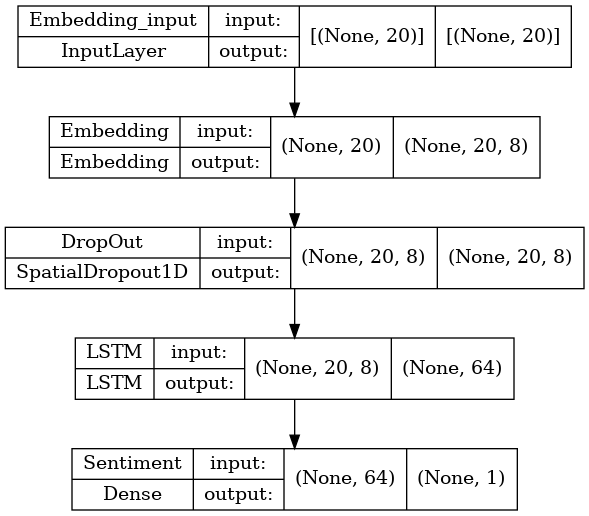

In [21]:
# trial model
s1 = senti(dict(pGrid.iloc[3]))
display(s1.summary())
plot_model(s1,show_shapes=True)

In [22]:
%%time
# trial run (base model)
fParams = dict(x=x_train,y=y_train,steps_per_epoch=200,
                 batch_size=32,epochs=20,validation_steps=100,
                 validation_data=(x_test,y_test))
s1 = runs(senti,"base",3,dict(pGrid.iloc[3]),fParams)

2022-06-24 22:18:53.963214: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


CPU times: user 27.2 s, sys: 2.75 s, total: 30 s
Wall time: 17.3 s


In [23]:
# Random consistency seed
np.random.seed(129)
tf.random.set_seed(129)
 
index = np.random.choice(list(pGrid.loc[pGrid.epoch.isna()].index),12,replace=False)

fParams = dict(x=x_train,y=y_train,steps_per_epoch=200,
                 batch_size=32,epochs=20,validation_steps=100,
                 validation_data=(x_test,y_test))

for i in tqdm(index,desc="hyperTuning"):
    sClf = runs(senti,"tune",i,dict(pGrid.iloc[i]),fParams)

hyperTuning: 100%|██████████████████████████████| 12/12 [03:23<00:00, 16.92s/it]


In [24]:
# lets review the results
pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="val_accuracy",ascending=False).head()

,embd,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy
1,8.0,64.0,0.2,0.010,20.0,0.376099,0.827008,0.509478,0.772187
11,8.0,96.0,0.4,0.001,20.0,0.442896,0.797522,0.488761,0.770312
8,8.0,96.0,0.2,0.001,20.0,0.411427,0.814147,0.493900,0.769687
50,32.0,128.0,0.2,0.001,20.0,0.385342,0.821205,0.488715,0.769063
52,32.0,128.0,0.4,0.010,20.0,0.376295,0.836104,0.501850,0.767812


In [25]:
%%time
# lets pick the best model and train on complete dataset
i = pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="val_accuracy",ascending=False).index[0]
gp = dict(pGrid.iloc[i])
fParams = dict(x=x_train,y=y_train,batch_size=32,
               epochs=20,validation_data=(x_test,y_test))
SentiCLF = runs(senti,"FINAL",i,gp,fParams)

CPU times: user 1min 51s, sys: 11.3 s, total: 2min 3s
Wall time: 1min 6s


In [26]:
# parameterize overfitting
pGrid["overFit"] = pGrid.apply(lambda row: row["val_accuracy"]-row["accuracy"],axis=1)

In [27]:
# review based on overfitting
pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="overFit",ascending=False).head()

,embd,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy,overFit
42,32.0,96.0,0.2,0.100,20.0,0.800294,0.503921,0.800210,0.530000,0.026079
12,8.0,128.0,0.2,0.100,20.0,0.857168,0.503450,0.798900,0.519687,0.016237
3,8.0,64.0,0.4,0.100,20.0,0.765087,0.503450,0.761148,0.505313,0.001862
11,8.0,96.0,0.4,0.001,20.0,0.442896,0.797522,0.488761,0.770312,-0.027209
5,8.0,64.0,0.4,0.001,20.0,0.440620,0.796895,0.486981,0.767187,-0.029707


In [28]:
%%time
# lets pick the model with least overfitting & train on full dataset
j = pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="overFit",ascending=False).index[0]
gp = dict(pGrid.iloc[j])
fParams = dict(x=x_train,y=y_train,batch_size=32,
               epochs=20,validation_data=(x_test,y_test))
SentiCLF2 = runs(senti,"FINAL2",j,gp,fParams)

CPU times: user 1min 52s, sys: 11.4 s, total: 2min 4s
Wall time: 1min 6s


In [29]:
# update & review results
pGrid["overFit"] = pGrid.apply(lambda row: row["val_accuracy"]-row["accuracy"],axis=1)
pGrid.iloc[[i,j]]

,embd,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy,overFit
1,8.0,64.0,0.2,0.01,20.0,0.325285,0.86320,0.528382,0.75892,-0.10428
42,32.0,96.0,0.2,0.10,20.0,0.774462,0.53988,0.756163,0.56720,0.02732


In [30]:
# choose the better one
if pGrid.loc[i,["val_accuracy"]].values[0] > pGrid.loc[j,["val_accuracy"]].values[0]:
    fModel = SentiCLF
else:
    fModel = SentiCLF2

while only a slight improvement is found in validation accuracy between last 2 full model runs<br>
all models fairly perform for the given limitiations of 10000 vocabulary & document cap of 20 lengths<br>
lets use the last model to predict sentiment for few documents

**Steps and tasks:**<br>
6. Use the designed model to print the prediction on any one sample.

In [31]:
index = np.random.randint(0,len(x_test),size=5)
pred = (fModel.predict(x_test[index])>0.5)*1
for j,i in enumerate(index):
    sentence = ' '.join([id2w[seq] for seq in x_test[i]])
    print('\033[1m'+"FEATURES:"+'\033[0m')
    print(sentence)
    print('\033[1m'+"TRUE LABEL"+'\033[0m')
    print(y_train[i])
    print('\033[1m'+"PREDICTED LABEL"+'\033[0m')
    print(pred[j])
    print("="*100,'\n')

FEATURES:
i i was painful in can as on cast not how watching part in smoking some to realistic of material
TRUE LABEL
[0]
PREDICTED LABEL
[0]

FEATURES:
way film becoming sustain in of difficult boasts better in negative not_in_here even by this could've bollywood bit that still
TRUE LABEL
[0]
PREDICTED LABEL
[0]

FEATURES:
it's his as it these is hoping you in change to time done unfortunately make am i'll to italian since
TRUE LABEL
[1]
PREDICTED LABEL
[1]

FEATURES:
film room coup boyle not_in_here not_in_here legend to adolescent not_in_here give cinema are in lost not_in_here are of not_in_here nemesis
TRUE LABEL
[1]
PREDICTED LABEL
[1]

FEATURES:
just is cena of once prior of fundamental kelly from single we offense movie of father up without wwii '
TRUE LABEL
[0]
PREDICTED LABEL
[1]



## Part B

**DOMAIN:** Social media analytics<br>
**• CONTEXT:** Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.<br>
**• DATA DESCRIPTION:**<br>
The dataset is collected from two news websites, theonion.com and huf ingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets: Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of inding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements<br>
**Content:** Each record consists of three attributes:<br>
**is_sarcastic:** 1 if the record is sarcastic otherwise 0<br>
**headline:** the headline of the news article<br>
**article_link:** link to the original news article. Useful in collecting supplementary data<br>
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection<br>
**• PROJECT OBJECTIVE:** Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.

**Steps and tasks:**<br>
1. Read and explore the data

In [2]:
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input
from tensorflow.keras.layers import Dropout, Bidirectional, GRU

import re, emoji, nltk, html
from num2words import num2words
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag 
from string import punctuation
from sklearn.model_selection import train_test_split
from keras.preprocessing import text, sequence

In [3]:
news = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)
news.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
# review the data properties
news.shape

(28619, 3)

In [5]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
# check for null/nan values
news.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
# check for support of sentiment classes
news.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [8]:
# count total words & vocabulary in headlines
vocab = set()
wordCount = 0
def wCount(doc):
    global wordCount,vocab
    doc = doc.split()
    vocab.update(doc)
    wordCount+=len(doc)

tqdm.pandas(desc="wordCount")
news.headline.progress_apply(lambda x: wCount(x));

wordCount: 100%|██████████████████████| 28619/28619 [00:00<00:00, 436940.70it/s]


In [9]:
# counts
len(vocab),wordCount

(38234, 287620)

**Steps and tasks:**<br>
2. Retain relevant columns<br>
3. Get length of each sentence

In [10]:
# drop article link
news.drop(["article_link"],axis=1,inplace=True)

In [11]:
tqdm.pandas(desc="wordLengths")
news["wordLength"] = news.headline.progress_apply(lambda x: len(x.split()))

wordLengths: 100%|████████████████████| 28619/28619 [00:00<00:00, 415868.80it/s]


In [12]:
news.wordLength.describe(percentiles=np.arange(0.9,1,0.01))

count    28619.000000
mean        10.049967
std          3.388307
min          2.000000
50%         10.000000
90%         14.000000
91%         14.000000
92%         15.000000
93%         15.000000
94%         15.000000
95%         16.000000
96%         16.000000
97%         17.000000
98%         17.000000
99%         19.000000
max        151.000000
Name: wordLength, dtype: float64

upto 99% of the headlines are less than 20 words long

**Steps and tasks:**<br>
4. Define parameters<br>
6. Create features and labels<br>
7. Get vocabulary size<br>
8. Create a weight matrix using GloVe embeddings<br>

In [13]:
# prerequisites
# sWords = stopwords.words('english') + list(punctuation)
lemma = WordNetLemmatizer().lemmatize

lemmaPOS = {p:'v' for p in ['VB','VBD','VBG','VBN','VBP','VBZ']}
lemmaPOS.update({p:'a' for p in ['JJ','JJR','JJS']})
lemmaPOS.update({p:'r' for p in ['RB','RBR','RBS']})
        
def wordy(doc):
    """parse & process each document"""
    
    # convert all html escape characters
    doc = html.unescape(doc)
    
    # demojize:convert emojies to word expressions & return 
    doc = emoji.demojize(doc,delimiters=(" "," "))
    
    # convert numbers to words
    for match in re.findall(r'([0-9]+[\.]{0,1}[0-9])|([0-9])',doc):
        match = np.sort(np.array(match))[-1]
        doc = re.sub(match,' '+num2words(match)+' ',doc)
        
    # remove any remaining non-alphabets
    doc = re.sub(r'[^a-zA-Z\s]','',doc)
    
    # tokenize
    # POS tagging
    wordTags = pos_tag(word_tokenize(doc))
    
    # ignore stop words
    # cast to lowercase
    # lemmatize
    words = np.array([lemma(word.lower(),lemmaPOS.get(tag,'n')) for (word,tag) in wordTags])
    
    return ' '.join(words)

In [14]:
# try wordy
wordy(news.headline[234])

'ten bad provision in the republican appropriation bill'

In [15]:
# extract tokenized words
tqdm.pandas(desc="wordy")
news["cleaned"] = news.headline.progress_apply(lambda x: wordy(x))

wordy: 100%|████████████████████████████| 28619/28619 [00:17<00:00, 1646.13it/s]


In [16]:
X = news.cleaned.values
Y = news.is_sarcastic.values
X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                    test_size=0.2,random_state=129)

In [17]:
# limit vocabulary to 10000
max_w = 10000
tokens = text.Tokenizer(num_words=max_w,oov_token=0)
tokens.fit_on_texts(X_train)
X_train_seq = tokens.texts_to_sequences(X_train)
X_test_seq = tokens.texts_to_sequences(X_test)

In [18]:
# limit document length = 20
X_train_sents = sequence.pad_sequences(X_train_seq, maxlen=20)
X_test_sents = sequence.pad_sequences(X_test_seq, maxlen=20)

In [19]:
# word index
w2id = tokens.word_index
id2w = dict(zip(w2id.values(),w2id.keys()))

In [20]:
# vocab size
max(id2w)

21234

In [21]:
# read GloVe vectors
file = open('glove.6B.50d.txt','rt')
gloveVec={}
for i in tqdm(range(int(40000))):
    try:
        line = file.readline().split(sep=' ')
        gloveVec.update({line[0]:np.array(line[1:], dtype='float32')})
    except:
        print(line)
        break
file.close()

100%|█████████████████████████████████| 40000/40000 [00:00<00:00, 123633.51it/s]


In [22]:
emb_matrix = np.zeros((max_w,50))
for i,w in id2w.items():
    if i < max_w:
        emb = gloveVec.get(w,0)
        if emb is not 0:
            emb_matrix[i] = emb

<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_46748/3754826333.py:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if emb is not 0:


**Steps and tasks:**<br>
9. Define and compile a Bidirectional LSTM model.<br>
10. Fit the model and check the validation accuracy

In [23]:
# constants
nVocab = max_w
inpSize = 20
embd = 50

In [24]:
#let us define a model generating method
def news(gridPoint):
    lstmN = int(gridPoint["lstmN"])
    dOut = gridPoint["dOut"]
    lr = gridPoint["lRate"]
    
    global nVocab, inpSize, embd, emb_matrix
    
    # Random consistency seed
    np.random.seed(129)
    tf.random.set_seed(129)
    
    # cuDNN requirements for LSTM acceleration
    lstmParams = dict(activation = 'tanh',
                      recurrent_activation = 'sigmoid',
                      recurrent_dropout = 0, 
                      unroll = False, use_bias = True)
    
    # model building
    model = Sequential()
    model.add(Embedding(nVocab,embd,
                        input_length=inpSize,name='Embedding'))
    model.add(SpatialDropout1D(dOut,name="DropOut"))
    model.add(Bidirectional(LSTM(lstmN,dropout=dOut/2,name="LSTM",**lstmParams),name="Bidirectional"))
    model.add(Dense(1,activation='sigmoid',name="Sentiment"))
    
    # GloVe embeddings
    model.layers[0].set_weights([emb_matrix])
    model.layers[0].trainable = False
    
    # compile
    optim = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optim, metrics=["accuracy"])
    
    return model

In [25]:
grid = dict(lstmN=[64,96,128],
            dOut=[0.2,0.4],
            lRate=[0.1,1e-2,1e-3])

pCols = list(grid.keys())

pGrid = pd.DataFrame(columns=pCols)
for gp in [np.array([l,d,lr]) 
           for l in grid["lstmN"] 
           for d in grid["dOut"] 
           for lr in grid["lRate"]]:
    dtmp = pd.DataFrame(gp.reshape(1,-1),columns=pCols)
    pGrid = pd.merge(pGrid,dtmp,how='outer',on=pCols)

pGrid["epoch"] = np.nan
pGrid.shape

(18, 4)

2022-06-24 23:26:57.274611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 23:26:57.311795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 23:26:57.311977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 23:26:57.312655: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 20, 50)            500000    
                                                                 
 DropOut (SpatialDropout1D)  (None, 20, 50)            0         
                                                                 
 Bidirectional (Bidirectiona  (None, 256)              183296    
 l)                                                              
                                                                 
 Sentiment (Dense)           (None, 1)                 257       
                                                                 
Total params: 683,553
Trainable params: 183,553
Non-trainable params: 500,000
_________________________________________________________________


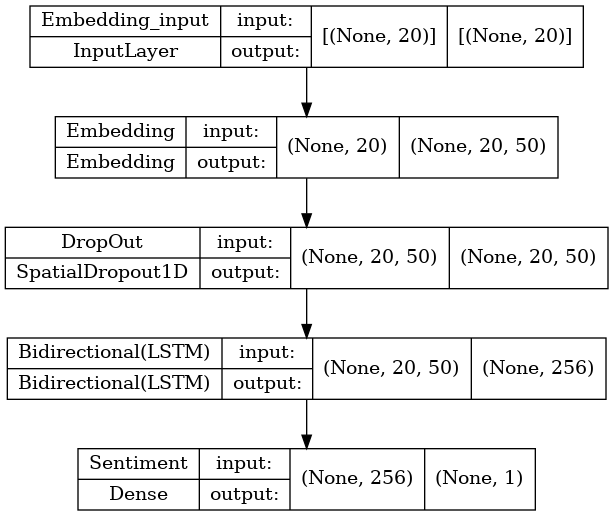

In [26]:
# sample model 12 (arbitrariliy chosen)
i = 12
gp = dict(pGrid.iloc[i])
mdl = news(gp)
mdl.summary()
plot_model(mdl,show_shapes=True)

In [34]:
%%time
# trial run (base model)
fParams = dict(x=X_train_sents,y=y_train,steps_per_epoch=200,
                 batch_size=32,epochs=20,validation_steps=100,
                 validation_data=(X_test_sents,y_test))
n1 = runs(news,"base",i,gp,fParams)

2022-06-24 23:27:46.372694: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


CPU times: user 42.3 s, sys: 5.02 s, total: 47.4 s
Wall time: 27.8 s


In [35]:
pGrid

,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy
0,64.0,0.2,0.100,NaN,NaN,NaN,NaN,NaN
1,64.0,0.2,0.010,NaN,NaN,NaN,NaN,NaN
2,64.0,0.2,0.001,NaN,NaN,NaN,NaN,NaN
3,64.0,0.4,0.100,NaN,NaN,NaN,NaN,NaN
4,64.0,0.4,0.010,NaN,NaN,NaN,NaN,NaN
5,64.0,0.4,0.001,NaN,NaN,NaN,NaN,NaN
6,96.0,0.2,0.100,NaN,NaN,NaN,NaN,NaN
7,96.0,0.2,0.010,NaN,NaN,NaN,NaN,NaN
8,96.0,0.2,0.001,NaN,NaN,NaN,NaN,NaN
9,96.0,0.4,0.100,NaN,NaN,NaN,NaN,NaN


In [36]:
# Random consistency seed
np.random.seed(129)
tf.random.set_seed(129)
 
index = np.random.choice(list(pGrid.loc[pGrid.epoch.isna()].index),12,replace=False)

fParams = dict(x=X_train_sents,y=y_train,steps_per_epoch=200,
                 batch_size=32,epochs=20,validation_steps=100,
                 validation_data=(X_test_sents,y_test))

for i in tqdm(index,desc="hyperTuning"):
    nClf = runs(news,"nTune",i,dict(pGrid.iloc[i]),fParams)

hyperTuning: 100%|██████████████████████████████| 12/12 [04:56<00:00, 24.72s/it]


In [37]:
# parameterize overfitting
pGrid["overFit"] = pGrid.apply(lambda row: row["val_accuracy"]-row["accuracy"],axis=1)
# review based on overfitting
pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="overFit",ascending=False).head()

,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy,overFit
0,64.0,0.2,0.100,20.0,0.739778,0.585156,0.663046,0.638438,0.053281
10,96.0,0.4,0.010,20.0,0.477844,0.767500,0.418665,0.807187,0.039688
4,64.0,0.4,0.010,20.0,0.474284,0.771094,0.404873,0.806562,0.035469
3,64.0,0.4,0.100,20.0,0.886616,0.500938,0.757501,0.515312,0.014375
14,128.0,0.2,0.001,20.0,0.396412,0.818125,0.388313,0.828438,0.010312


In [39]:
%%time
# lets pick the model with least overfitting & train on full dataset
i = pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="overFit",ascending=False).index[0]
gp = dict(pGrid.iloc[i])
fParams = dict(x=X_train_sents,y=y_train,batch_size=32,
               epochs=20,validation_data=(X_test_sents,y_test))
NewsCLF = runs(news,"nFINAL",i,gp,fParams)

CPU times: user 1min 48s, sys: 13.1 s, total: 2min 2s
Wall time: 1min 3s


In [40]:
# review based on overfitting
pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="val_accuracy",ascending=False).head()

,lstmN,dOut,lRate,epoch,loss,accuracy,val_loss,val_accuracy,overFit
13,128.0,0.2,0.010,20.0,0.375911,0.834687,0.372078,0.839063,0.004375
1,64.0,0.2,0.010,20.0,0.374197,0.834063,0.381996,0.829063,-0.005000
14,128.0,0.2,0.001,20.0,0.396412,0.818125,0.388313,0.828438,0.010312
2,64.0,0.2,0.001,20.0,0.408778,0.811406,0.405476,0.820000,0.008594
10,96.0,0.4,0.010,20.0,0.477844,0.767500,0.418665,0.807187,0.039688


In [42]:
%%time
# lets pick the model with least overfitting & train on full dataset
j = pGrid.loc[pGrid.epoch.isna()!=True].sort_values(by="val_accuracy",ascending=False).index[0]
gp = dict(pGrid.iloc[j])
fParams = dict(x=X_train_sents,y=y_train,batch_size=32,
               epochs=20,validation_data=(X_test_sents,y_test))
NewsCLF2 = runs(news,"nFINAL2",j,gp,fParams)

CPU times: user 1min 56s, sys: 13 s, total: 2min 9s
Wall time: 1min 16s


In [47]:
# choose the better one
if pGrid.loc[i,["val_accuracy"]].values[0] > pGrid.loc[j,["val_accuracy"]].values[0]:
    fModel = NewsCLF
else:
    fModel = NewsCLF2

In [50]:
print("VALDIATION ACCURACY: ",fModel.evaluate(X_test_sents,y_test,verbose=0)[1])

VALDIATION ACCURACY:  0.8331586122512817
